2000
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64
1    500
2    500
3    500
0    500
Name: price_range, dtype: int64


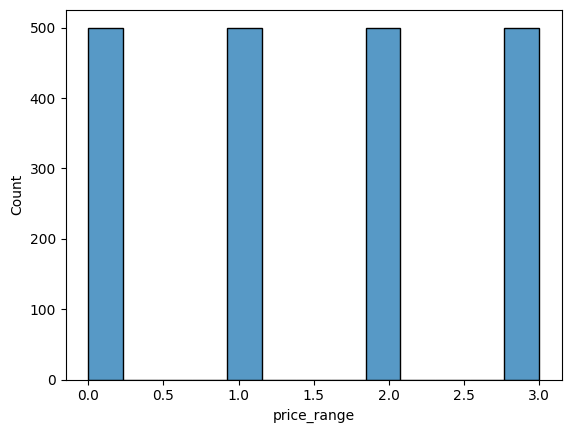

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('train.csv')

print(df.shape[0])
print(df.isna().sum())
print(df['price_range'].value_counts())

sns.histplot(df, x='price_range')
plt.show()

int64
price_range
0    5.682
1    5.544
2    5.714
3    6.128
Name: sc_w, dtype: float64


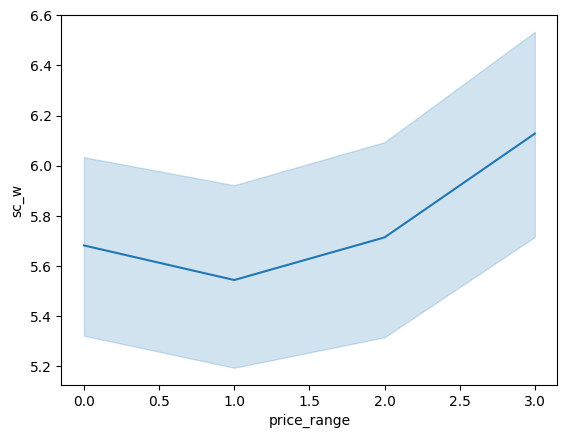

price_range
0    6.299335
1    6.132743
2    6.265351
3    6.646421
Name: sc_w, dtype: float64


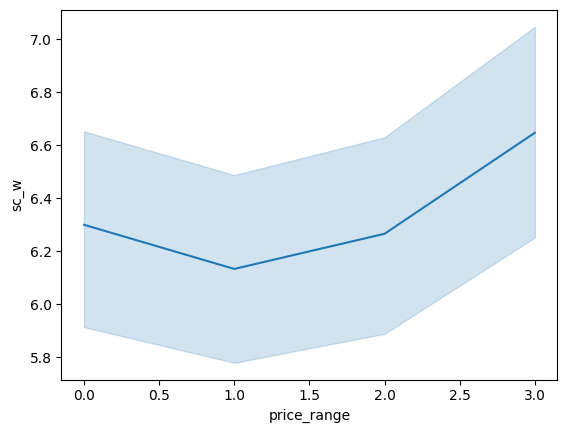

In [55]:
print(df['sc_w'].dtype)
print(df.groupby('price_range')['sc_w'].mean())
sns.lineplot(df, x='price_range', y='sc_w')
plt.show()

df1 = df[df['sc_w'] > 0]
print(df1.groupby('price_range')['sc_w'].mean())
sns.lineplot(df1, x='price_range', y='sc_w')
plt.show()

price_range
0    1116.902
1    1228.868
2    1228.320
3    1379.984
Name: battery_power, dtype: float64


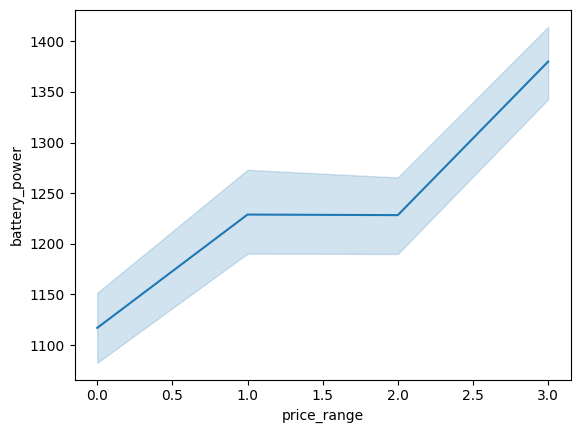

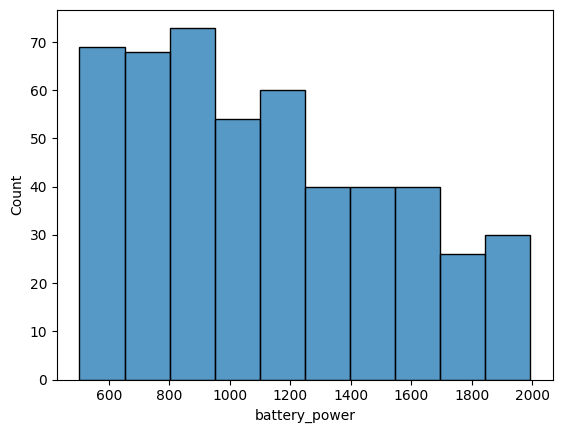

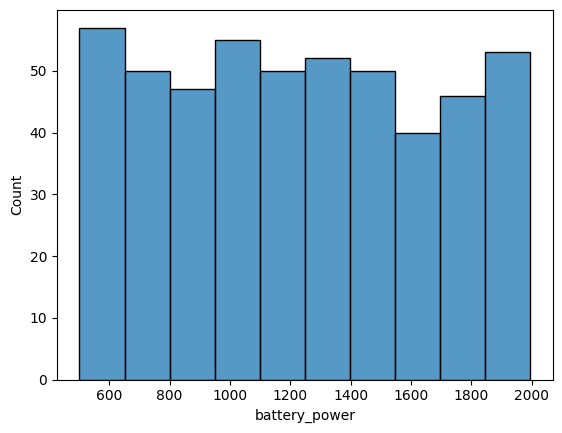

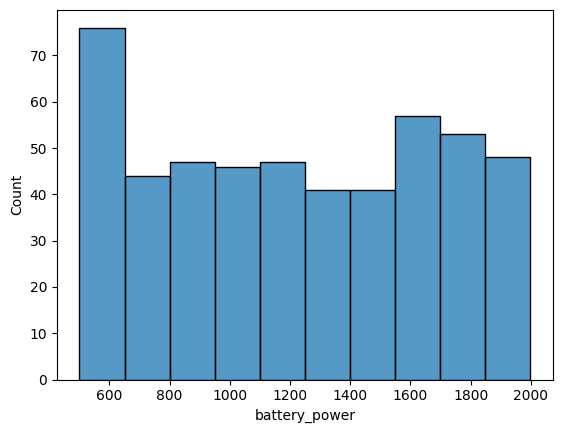

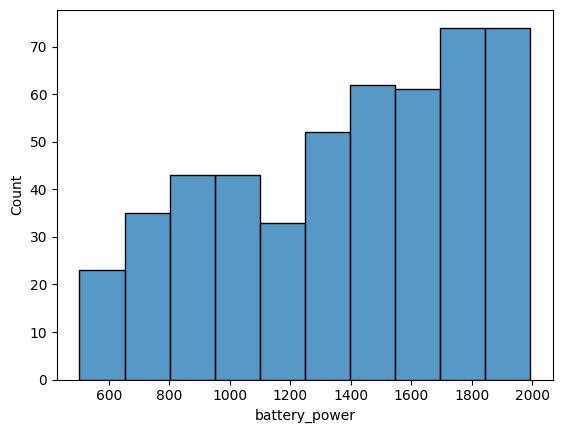

In [56]:
print(df.groupby('price_range')['battery_power'].mean())
sns.lineplot(df, x='price_range', y='battery_power')
plt.show()

for i in range(4):
    df_bp = df[df['price_range'] == i]
    sns.histplot(df_bp, x='battery_power')
    plt.show()

In [57]:
df_4g = df[df['four_g'] == 1]
print(df_4g['three_g'].value_counts())

1    1043
Name: three_g, dtype: int64


In [58]:
df_4g = df[df['four_g'] == 1]
print(df_4g[df_4g['wifi'] == 0]['wifi'].value_counts())
print(df_4g[df_4g['blue'] == 0]['blue'].value_counts())

0    523
Name: wifi, dtype: int64
0    520
Name: blue, dtype: int64


Predizione decision tree Test: 0.81 Train: 1.0
Predizione logistic regression Test: 0.65 Train: 0.6326666666666667


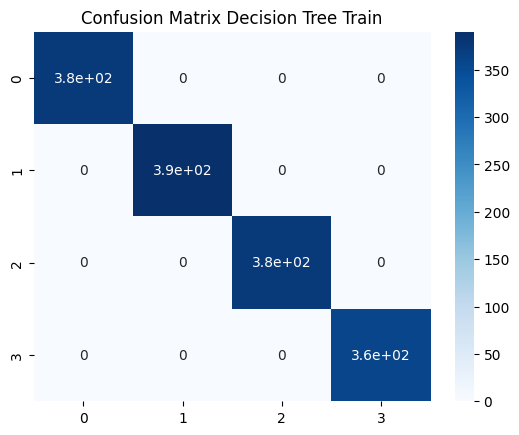

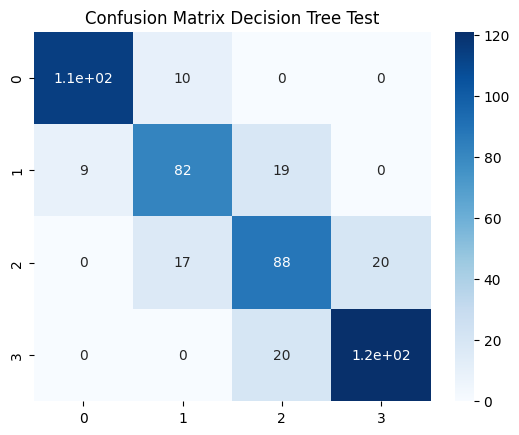

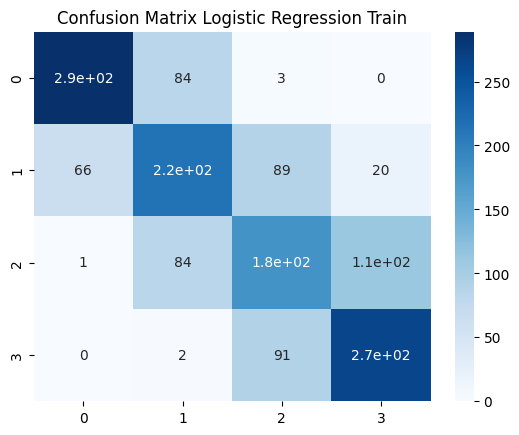

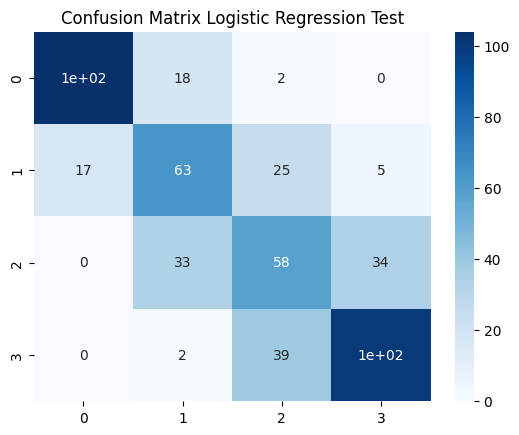

In [59]:
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

y = df['price_range']
X = df.drop('price_range', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=1/4, random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

test_pred = tree.predict(X_test)
train_pred = tree.predict(X_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

test_pred1 = logreg.predict(X_test)
train_pred1 = logreg.predict(X_train)
print(f'Predizione logistic regression Test: {accuracy_score(y_test, test_pred1)} Train: {accuracy_score(y_train, train_pred1)}')

sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_pred), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_pred), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Test')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_pred1), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_pred1), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Test')
plt.show()

In [60]:
print('Accuracy Decision Tree con Cross Val ',cross_val_score(tree, X, y, cv=10, scoring='accuracy').mean())
print('Accuracy Logistic Regression con Cross Val ',cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

Accuracy Decision Tree con Cross Val  0.8325000000000001
Accuracy Logistic Regression con Cross Val  0.6395000000000001


In [61]:
from sklearn.model_selection import GridSearchCV

params = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'min_samples_split' : [2,3,4,5,10]
}
gs = GridSearchCV(tree, params, scoring='accuracy', cv=10, verbose=1)
gs.fit(X_train, y_train)

test_pred = gs.predict(X_test)
train_pred = gs.predict(X_train)
print(gs.best_params_)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

Fitting 10 folds for each of 45 candidates, totalling 450 fits
{'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 3}
Predizione decision tree Test: 0.524 Train: 0.976


In [62]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

scaled_value = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_value, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y , test_size=1/4)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

test_pred = tree.predict(X_test)
train_pred = tree.predict(X_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

Predizione decision tree Test: 0.82 Train: 1.0


In [63]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

trasformers = [
    ('discr', KBinsDiscretizer(n_bins=4, encode='onehot'), ['ram'])
]
ct = ColumnTransformer(transformers=trasformers, remainder='passthrough', verbose=True)
model = DecisionTreeClassifier()

temp = ct.fit_transform(X, y)
df_discr = pd.DataFrame(temp, columns=ct.get_feature_names_out(X.columns))
X_train, X_test, y_train, y_test = train_test_split(df_discr, y , test_size=1/4)

model.fit(X_train,y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')


[ColumnTransformer] ......... (1 of 2) Processing discr, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
Predizione decision tree Test: 0.714 Train: 1.0


In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

trasformers_2 = [
    ('discr1', KBinsDiscretizer(n_bins=4), ['ram']),
    ('discr2', KBinsDiscretizer(n_bins=10), ['battery_power'])
]

ct1 = ColumnTransformer(transformers=trasformers_2, remainder='passthrough', verbose=True)

prepo = Pipeline(steps=[
    ('ct1', ct1),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

Xt = prepo.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(Xt, y , test_size=1/4)
model.fit(X_train, y_train)
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

[ColumnTransformer] ........ (1 of 3) Processing discr1, total=   0.0s
[ColumnTransformer] ........ (2 of 3) Processing discr2, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s
Predizione decision tree Test: 0.71 Train: 1.0
